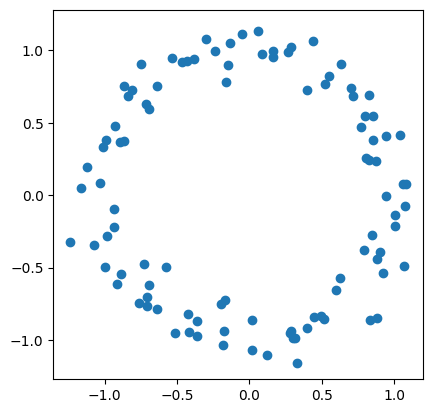

In [1]:
import numpy as np
import recycle as re
import matplotlib.pyplot as plt
from ripser import Rips
from persim import plot_diagrams
from scipy.linalg import svdvals

x = np.linspace(0, 8 * np.pi, 100)
points = np.c_[np.sin(x), np.cos(x)]
circle = points + np.random.normal(0, 0.1, size=(points.shape))

plt.scatter(circle[:, 0], circle[:, 1])
plt.axis("square")
plt.show()


# Solve Homology to get Initial Representative

In [2]:
# GET THE INITIAL REPRESENTATIVE
def boundary_and_representative(points,max_edge_length,slack_factor = None):
    dimension = 2
    #max_edge_length = death * 1.01  # give a bit of slack
    
    gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)
    (
        representative,
        boundary_map,
        reduced_boundary_base,
        (birth_simplex,death_simplex)
    ) = re.core.get_representative_and_complex(gudhi_complex, dimension)
    
    # Get the actual values of birth and death
    birth,death = gudhi_complex.filtration(birth_simplex),gudhi_complex.filtration(death_simplex)
    min_persistence = (death - birth) if slack_factor is None else (death - birth) * slack_factor
    
    order_function = lambda s: (gudhi_complex.filtration(s), s)
    # ISOLATED
    np1_simplices = sorted(
        {
            simplex
            for simplex in reduced_boundary_base
            if gudhi_complex.filtration(simplex) <= (death - min_persistence)*1.01 #slack for rounding errors
        },
        key=order_function,
    )
    n_simplices = sorted(
        {
            tuple(sorted(simplex))
            for simplex, radius in gudhi_complex.get_filtration()
            if len(simplex) == dimension and radius <= (death - min_persistence)*1.01 #slack for rounding errors
        },
        key=order_function,
    )
    nm1_simplices = sorted(
        {
            tuple(sorted(simplex))
            for simplex, radius in gudhi_complex.get_filtration()
            if len(simplex) == dimension - 1 and radius <= (death - min_persistence)*1.01 #slack for rounding errors
        },
        key=order_function,
    )
            
    x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
    boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)
    return boundary_matrix, x_orig, n_simplices, representative, (birth_simplex,death_simplex)

# Objective Functions
- L1
- Distance
- Time

In [3]:
#helper function to create the length weight matrix
def edge_length_function(points):
    def edge_length(simp1, simp2):
        if simp1 == simp2:
            return np.linalg.norm(points[simp1[0]] - points[simp1[1]])
        else:
            return 0

    return edge_length

def optimize_cycle(W, x_orig, boundary_matrix, n_simplices):
    # Run optimization
    x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
        boundary_matrix, x_orig, W, use_gurobi=True
    )
    print("Objective value (L1 norm of x):", objective_value)
    min_cycle = set(
        [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
    )  # be carefull here with values close to zero, add a tolerance parameter
    return min_cycle

def barcode_biggest_cycle(diags):
    persistence = diags[1][:, 1] - diags[1][:, 0]
    cycle = np.argmax(persistence)
    birth, death = diags[1][cycle]
    return birth,death

In [178]:
from collections import Counter
results = []
N_ITERATIONS = 100
for PERTURB_AMOUNT in np.linspace(0.01,0.25,5):
    for SLACK in [1, 0.5]:
        len_cycles,l0_cycles = [],[]
        for _ in range(N_ITERATIONS):
            perturbed_points = circle+np.random.normal(0, PERTURB_AMOUNT, size=(circle.shape))
            rips = Rips()
            diags = rips.fit_transform(perturbed_points)
            _,death = barcode_biggest_cycle(diags)
            max_edge_length = death*1.01 #give it a bit of slack
            boundary_matrix,x_orig,n_simplices,representative,longest_loop = boundary_and_representative(perturbed_points,
                                                                                            max_edge_length,
                                                                                            slack_factor=SLACK)
            
            # Len_optimization
            W = re.core.create_weight_matrix(n_simplices, edge_length_function(perturbed_points))
            len_cycle = optimize_cycle(W, x_orig, boundary_matrix, n_simplices)
            len_cycles.append(len_cycle)
            if len(len_cycle) == 0:
                print("HERE")
                break 
        
             # Len_optimization
            l0_cycle = optimize_cycle(None, x_orig, boundary_matrix, n_simplices)
            l0_cycles.append(l0_cycle)
            if len(l0_cycle) == 0:
                print("big error")
                break 
        
        
    
        dist = list(Counter(item for tup in len_cycles for item in tup).values())
        dist = np.array(dist)/N_ITERATIONS
        results.append({
            "noise": PERTURB_AMOUNT,
            "slack": SLACK,
            "objective": "len",
            "cycles": len_cycles,
            "dist" : dist
        })
        
        dist = list(Counter(item for tup in l0_cycles for item in tup).values())
        dist = np.array(dist)/N_ITERATIONS
        results.append({
            "noise": PERTURB_AMOUNT,
            "slack": SLACK,
            "objective": "l0",
            "cycles": l0_cycles,
            "dist" : dist
        })

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/antonio/gurobi.lic
Academic license - for non-commercial use only - expires 2025-10-30

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/7d2f83075af347df959e68a6ca38422f-pulp.lp
Reading time = 0.00 seconds
OBJ: 264 rows, 692 columns, 1020 nonzeros

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 264 rows, 692 columns and 1020 nonzeros
Model fingerprint: 0x0cbe15cc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 175 rows and 203 columns
Presolve time: 0.0

KeyboardInterrupt: 

In [187]:
import pandas as pd
df = pd.DataFrame(results)
df = df[df["noise"]<0.17]

In [194]:
rips = Rips()
diags = rips.fit_transform(circle)
_,death = barcode_biggest_cycle(diags)
max_edge_length = death*1.01 #give it a bit of slack
len_baseline,l0_baseline={},{}

for SLACK in [1, 0.5]:
    boundary_matrix,x_orig,n_simplices,representative,longest_loop = boundary_and_representative(circle,
                                                                                    max_edge_length,
                                                                                    slack_factor=SLACK)
    # Len_optimization
    W = re.core.create_weight_matrix(n_simplices, edge_length_function(circle))
    len_cycle = optimize_cycle(W, x_orig, boundary_matrix, n_simplices)

     # Len_optimization
    l0_cycle = optimize_cycle(None, x_orig, boundary_matrix, n_simplices)
    len_baseline[SLACK] = len_cycle
    l0_baseline[SLACK] = l0_cycle

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/antonio/gurobi.lic
Academic license - for non-commercial use only - expires 2025-10-30

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/3d039eb344cd4269adb30c014a22656d-pulp.lp
Reading time = 0.00 seconds
OBJ: 276 rows, 729 columns, 1083 nonzeros

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 276 rows, 729 columns and 1083 nonzeros
Model fingerprint: 0xa81acc57
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 186 rows and 203 columns
Presolve time: 0.0

In [214]:
def get_stability_distribution(original_selection, new_selections):
    # Convert original selection to set for faster lookup
    original_items = set(original_selection)
    n_trials = len(new_selections)
    
    # Count appearances of each original item
    item_counts = Counter()
    for new_selection in new_selections:
        # Only count items that were in original selection
        for item in set(new_selection) & original_items:
            item_counts[item] += 1
    
    # Calculate percentage for each original item
    stability_dist = {
        item: (item_counts[item] / n_trials)
        for item in original_items
    }
    
    return stability_dist

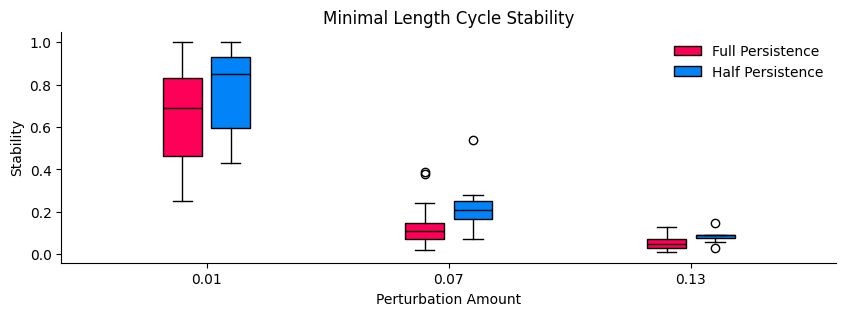

In [249]:
OBJECTIVE = "len"
plt.figure(figsize=(10, 3))

full_values,half_values = [],[]
# Get the data
for NOISE in df["noise"].unique():
    #get perturbed_cylces
    cycles_full = df[(df['noise'] == NOISE) & (df['slack'] == 1) & (df['objective'] == "len")]['cycles'].tolist()[0]
    cycles_half = df[(df['noise'] == NOISE) & (df['slack'] == 0.5) & (df['objective'] == "len")]['cycles'].tolist()[0]
    #get stability
    full_values.append(list(get_stability_distribution(len_baseline[1], cycles_full).values()))
    half_values.append(list(get_stability_distribution(len_baseline[0.5], cycles_half).values()))

# Create x-axis values
x_axis = np.round(df["noise"].unique(), 2)
positions = np.arange(len(x_axis))

# Create offset positions for the two sets of boxplots
offset = 0.2  # Adjust this value to control spacing between pairs
full_positions = positions - offset/2
half_positions = positions + offset/2

# Create the boxplots
box_plot = plt.boxplot(full_values, positions=full_positions, widths=offset*0.8, patch_artist=True,
            boxprops=dict(facecolor = '#FF0059',color='black'),
            tick_labels=[''] * len(full_positions))  # Empty labels for first set
for median in box_plot['medians']:
    median.set_color('black')
box_plot = plt.boxplot(half_values, positions=half_positions, widths=offset*0.8, patch_artist=True,
            boxprops=dict(facecolor='#0283F8', color='black'),
            tick_labels=[''] * len(half_positions))  # Empty labels for second set
for median in box_plot['medians']:
    median.set_color('black')
# Create custom legend handles
import matplotlib.patches as mpatches
full_patch = mpatches.Patch(facecolor='#FF0059',edgecolor='black', label='Full Persistence')
half_patch = mpatches.Patch(facecolor='#0283F8',edgecolor='black', label='Half Persistence')
plt.legend(handles=[full_patch, half_patch],frameon=False)
plt.ylabel("Stability")
plt.xlabel("Perturbation Amount")

ax= plt.gca()
ax.spines[['right', 'top']].set_visible(False)
# Set the actual labels in the middle positions
plt.title("Minimal Length Cycle Stability")
plt.xticks(positions, x_axis)
plt.show()





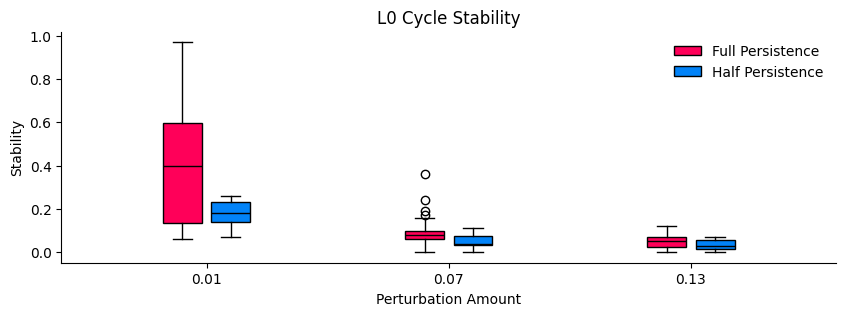

In [250]:
plt.figure(figsize=(10, 3))

full_values,half_values = [],[]
# Get the data
for NOISE in df["noise"].unique():
    #get perturbed_cylces
    cycles_full = df[(df['noise'] == NOISE) & (df['slack'] == 1) & (df['objective'] == "l0")]['cycles'].tolist()[0]
    cycles_half = df[(df['noise'] == NOISE) & (df['slack'] == 0.5) & (df['objective'] == "l0")]['cycles'].tolist()[0]
    #get stability
    full_values.append(list(get_stability_distribution(l0_baseline[1], cycles_full).values()))
    half_values.append(list(get_stability_distribution(l0_baseline[0.5], cycles_half).values()))

# Create x-axis values
x_axis = np.round(df["noise"].unique(), 2)
positions = np.arange(len(x_axis))

# Create offset positions for the two sets of boxplots
offset = 0.2  # Adjust this value to control spacing between pairs
full_positions = positions - offset/2
half_positions = positions + offset/2

# Create the boxplots
box_plot = plt.boxplot(full_values, positions=full_positions, widths=offset*0.8, patch_artist=True,
            boxprops=dict(facecolor = '#FF0059',color='black'),
            tick_labels=[''] * len(full_positions))  # Empty labels for first set
for median in box_plot['medians']:
    median.set_color('black')
box_plot = plt.boxplot(half_values, positions=half_positions, widths=offset*0.8, patch_artist=True,
            boxprops=dict(facecolor='#0283F8', color='black'),
            tick_labels=[''] * len(half_positions))  # Empty labels for second set
for median in box_plot['medians']:
    median.set_color('black')
# Create custom legend handles
import matplotlib.patches as mpatches
full_patch = mpatches.Patch(facecolor='#FF0059',edgecolor='black', label='Full Persistence')
half_patch = mpatches.Patch(facecolor='#0283F8',edgecolor='black', label='Half Persistence')
plt.legend(handles=[full_patch, half_patch],frameon=False)
plt.ylabel("Stability")
plt.xlabel("Perturbation Amount")

ax= plt.gca()
ax.spines[['right', 'top']].set_visible(False)
# Set the actual labels in the middle positions
plt.title("L0 Cycle Stability")
plt.xticks(positions, x_axis)
plt.show()




In [228]:
def plot_cycles(points,many_cycles,ax=None):
    if ax is None:
        fig,ax = plt.subplots()
    for cycle in many_cycles:
        for edge in cycle:
            ax.plot(*zip(points[edge[0]], points[edge[1]]), "-", color="#FF0059", alpha=0.1)
    ax.plot([], [], "--", color="k", alpha=0.5, label="Initial Representative")
    #ax.plot([], [], "-", color="#FF0059", label=label)
    ax.plot(*zip(*points), "o")
    ax.legend()
    ax.axis("equal")
    ax.axis("off")
    plt.show()